In [50]:
from zipfile import ZipFile as zp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input

In [6]:
# Reading the first 10 data from dataset

dz = zp("/content/archive.zip")
data = pd.read_csv(dz.open("fer2013.csv"))

data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [8]:
data.shape

(35887, 3)

In [18]:
data.isnull().sum()

,0
emotion,0
pixels,0
Usage,0


<Axes: >

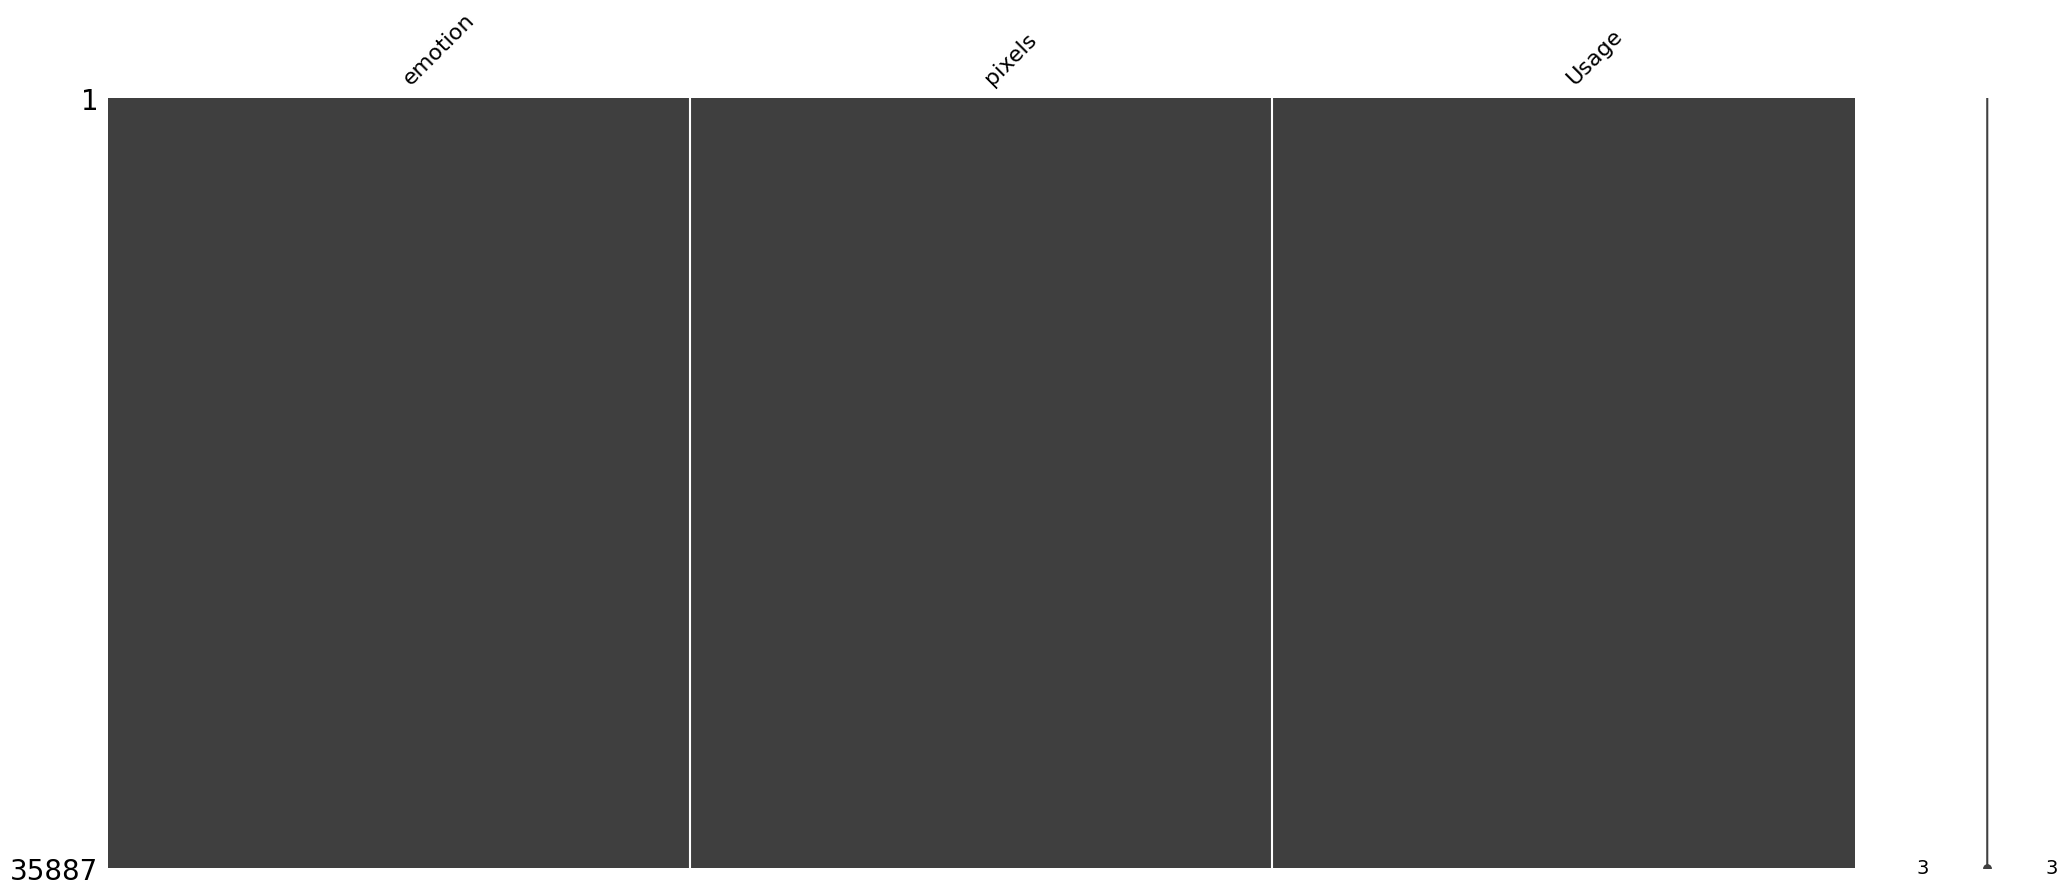

In [20]:
ms.matrix(data)

In [16]:
data['emotion'].value_counts().sort_values(ascending = False)

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


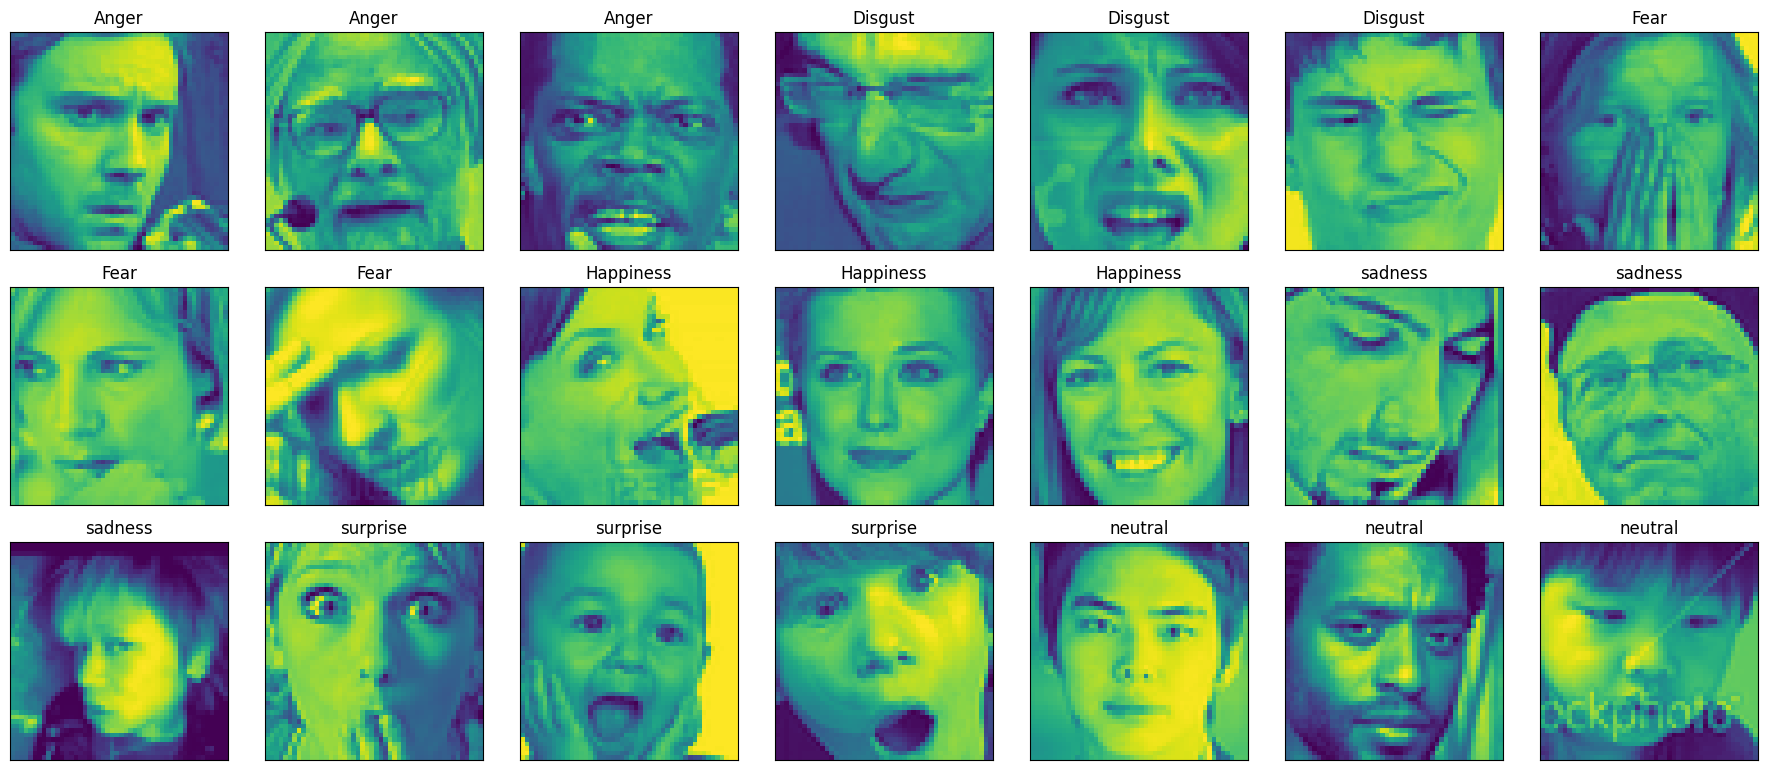

In [12]:
label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness',
                 4:'sadness', 5: 'surprise', 6: 'neutral'}


fig = plt.figure(1, (18, 18))
k = 0

for label in sorted(data.emotion.unique()):
    for j in range(3):
        px = data[data.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7,7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [30]:
# Splitting data

X = np.array([np.fromstring(pixels, sep=' ') for pixels in data['pixels']])
X = X.reshape(-1, 48, 48, 1).astype('float32') / 255.0  # Normalize
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to 3-channel RGB
y = data['emotion'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# cnn

def create_cnn():
    inputs = Input(shape=(48, 48, 3))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(7, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_cnn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 84s 228ms/step - accuracy: 0.2649 - loss: 1.7851 - val_accuracy: 0.3983 - val_loss: 1.5755
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 82s 227ms/step - accuracy: 0.3914 - loss: 1.5704 - val_accuracy: 0.4469 - val_loss: 1.4667
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.4496 - loss: 1.4442 - val_accuracy: 0.4753 - val_loss: 1.3717
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.4879 - loss: 1.3474 - val_accuracy: 0.5017 - val_loss: 1.3347
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 137s 225ms/step - accuracy: 0.5117 - loss: 1.2906 - val_accuracy: 0.5174 - val_loss: 1.2883


In [46]:
embedding_model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
X_train_embedding = embedding_model.predict(X_train)
X_test_embedding = embedding_model.predict(X_test)

898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step


In [47]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_embedding, y_train)

KNeighborsClassifier(n_neighbors=3)

In [54]:
# Evalutaion before hyperparameter tuning

pred = knn.predict(X_test_embedding)
acc = accuracy_score(y_test, pred)
print(f"Accuracy: {round(acc * 100, 2)} %")

Accuracy: 45.18 %


In [56]:
# Tuning model for KNN

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train_embedding, y_train)

best_knn = grid.best_estimator_
print("Parameters:", grid.best_params_)

# Evaluate after hyperparameter tuning
pred = best_knn.predict(X_test_embedding)
acc = accuracy_score(y_test, pred)
print(f"Accuracy after tuning: {round(acc * 100, 2)} %")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy after tuning: 51.46 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


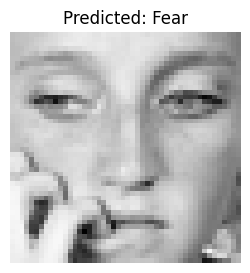

In [70]:
# Predict new image
i = random.randint(0, len(X_test) - 1)
face_img = np.expand_dims(X_test[i], axis=0)
face_embedding = embedding_model.predict(face_img)
e_pred = knn.predict(face_embedding)[0]
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plt.figure(figsize=(3, 3))
plt.imshow(X_test[i])
plt.title(f"Predicted: {emotions[e_pred]}")
plt.axis('off')
plt.show()